In [1]:
import os
os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from sdhm import SDHM
os.chdir(home_dir)

import numpy as np
import pandas as pd
import scipy.stats as st
import numpy.random as rd
import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("ggplot")

%matplotlib inline

# Access Tracer

1. 隠れマルコフモデルの混合分布による行動モデリング
2. 複数の混合隠れマルコフモデルのオンライン忘却型学習
3. 動的モデル選択による最適混合数の決定
4. スコアリング

## データ生成

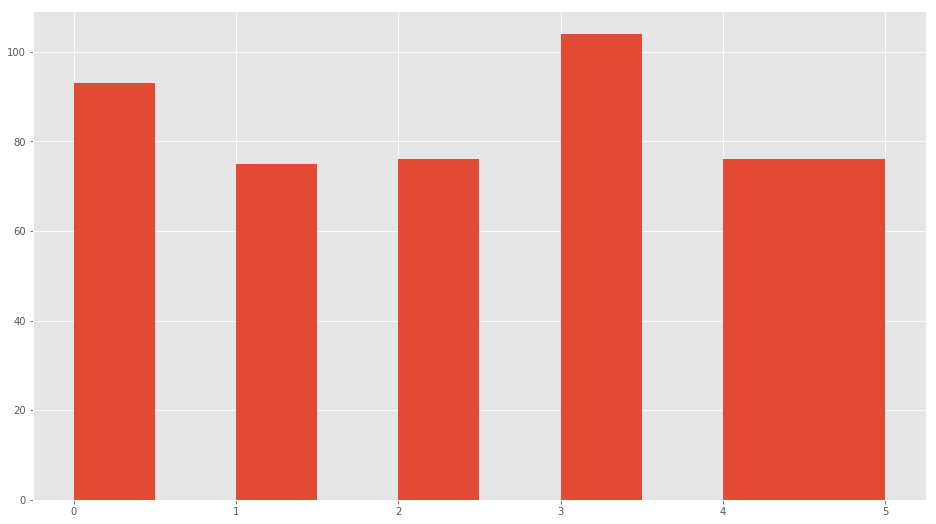

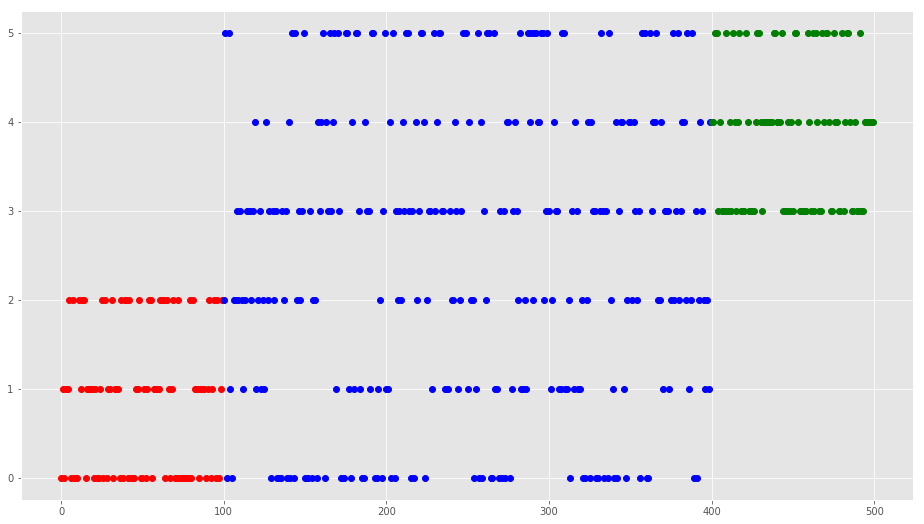

In [2]:
rd.seed(0)

dice1 = [0, 1, 2, 3, 4, 5]
dice2 = [0, 1, 2]
dice3 = [3, 4, 5]

y1 = rd.choice(dice2, 100)
flag1 = np.array([2 for i in range(100)])
y2 = rd.choice(dice1, 300)
flag2 = np.array([1 for i in range(300)])
y3 = rd.choice(dice3, 100)
flag3 = np.array([3 for i in range(100)])

y = np.concatenate([y1, y2, y3])
flag = np.concatenate([flag1, flag2, flag3])
data = np.concatenate([y[:, np.newaxis], flag[:, np.newaxis]], axis=1)
org_data = pd.DataFrame(data)

plt.figure(figsize=(16, 9))
plt.hist(org_data[0])
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(org_data.loc[org_data[1]==2][0], "o", c="r")
plt.plot(org_data.loc[org_data[1]==1][0], "o", c="b")
plt.plot(org_data.loc[org_data[1]==3][0], "o", c="g")
plt.show()

In [3]:
window_size = 5
y = np.array([np.array(org_data[0][i:i+window_size]) for i in range(org_data.shape[0]-window_size+1)])

## SDHM

In [4]:
# Given
r = 0.01 # 忘却パラメータ 0<r<1
nu = 0.1 # 推定係数
K = 3 # 混合数
n = 2 # HMMの次数
M = y.shape[0] # データ数
Tj = y.shape[1] # セッションの長さ
N1 = 3
N2 = 6

In [13]:
# 1〜Kまでの混合数でSDHMを初期化
sdhm = [SDHM(r, nu, k, Tj, N1, N2) for k in range(1, K+1)]

In [19]:
# 学習
for k in range(K):
    sdhm[k].train(y)

## 動的モデル選択による最適混合数の決定

In [33]:
# Given
K = range(K)
K_max = max(K) + 1
M = y.shape[0] # 総セッション数

In [34]:
# theta[0]
a = (sdhm[0].a[0], sdhm[1].a[0], sdhm[2].a[0])
b = (sdhm[0].b[0], sdhm[1].b[0], sdhm[2].b[0])
gamma = (sdhm[0].gamma[0], sdhm[1].gamma[0], sdhm[2].gamma[0])
pi = (sdhm[0].pi[0], sdhm[1].pi[0], sdhm[2].pi[0])

In [37]:
# initialize
j = 1
S = np.zeros((len(K), M, M))
KK = np.zeros((len(K), M, M))